# **Logical & Problem Solving**

## Demand Analysis

Please refer to the sample dataset `kamereo_test.xlsx`, sheet **"case study 1"** attached. Kamereo has historical data of transactions with customer 1 and customer 2. Based on the data:

a) Evaluate the performance of **Category A** (Using descriptive analysis, time-series analysis).

b) Forecast the daily performance of **Category A** in October and November. Explain your methodology.


In [83]:
import sys
import os

import pandas as pd
# Set display options to avoid scientific notation
pd.set_option('display.float_format', '{:.2f}'.format)

import numpy as np
import duckdb
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

In [84]:
# Get the current working directory
current_dir = os.getcwd()
# Move up one level from the current directory
parent_dir = os.path.dirname(current_dir)
# Change directory into data directory
data_dir = os.path.join(parent_dir, 'data')

In [85]:
df = pd.read_excel(os.path.join(data_dir, 'data_test.xlsx'), index_col=None)

In [86]:
df.head()

,a) Evaluate the performance of Category A,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,b) Predict the daily performance of Category A...,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,Date,Category A,Customer,Qty Sold,Revenue
4,20171001,A,2,18,4058699


# 1. **Data Cleaning**

## 1.1 Drop unnecessary rows

In [87]:
# Drop the first three rows
df = df.drop(index=[0, 1, 2])

# Reset index and drop the current index column
df = df.reset_index(drop=True)

# Promote the fourth row (now index 3) to header
df.columns = df.iloc[0]

# Drop the row that was promoted to header
df = df.drop(index=0).reset_index(drop=True)

In [88]:
df.head()

,Date,Category A,Customer,Qty Sold,Revenue
0,20171001,A,2,18,4058699
1,20171001,A,1,29,13178000
2,20171002,A,1,55,23493200
3,20171002,A,2,30,6540835
4,20171003,A,2,25,5888624


## 1.2 Format Columns Name

In [89]:
df.columns

Index(['Date', 'Category A', 'Customer', 'Qty Sold', 'Revenue'], dtype='object', name=0)

In [90]:
def rename_columns(df):
   # convert form camel case to snake case
   df.columns = (df.columns
                  .str.replace('(?<=[a-z])(?=[A-Z])', '_', regex=True)
                  .str.lower()
               )
   # convert " " to _
   df.columns = df.columns.str.replace(' ', '_')
   return df

In [91]:
df = rename_columns(df)

In [92]:
df.columns

Index(['date', 'category_a', 'customer', 'qty_sold', 'revenue'], dtype='object', name=0)

## 1.3 Format Date

In [93]:
# Convert the 'Date' column to datetime
df['date'] = pd.to_datetime(df['date'].astype(str), format='%Y%m%d')

In [94]:
df['date'] = pd.to_datetime(df['date'])

In [95]:
df[['date']].head()

,date
0,2017-10-01
1,2017-10-01
2,2017-10-02
3,2017-10-02
4,2017-10-03


## 1.4 Format Datatypes

In [96]:
df.dtypes

0
date          datetime64[ns]
category_a            object
customer              object
qty_sold              object
revenue               object
dtype: object

In [97]:
# Convert 'qty_sold' and 'revenue' from object to integer
df['qty_sold'] = df['qty_sold'].astype(int)
df['revenue'] = df['revenue'].astype(int)

In [98]:
df.dtypes

0
date          datetime64[ns]
category_a            object
customer              object
qty_sold               int64
revenue                int64
dtype: object

# 2. Attribute Combination

In [99]:
df.columns

Index(['date', 'category_a', 'customer', 'qty_sold', 'revenue'], dtype='object', name=0)

In [100]:
# Calculate the average price and round it
df['avg_price'] = (df['revenue'] / df['qty_sold']).round(2)

In [101]:
df.head(3)

,date,category_a,customer,qty_sold,revenue,avg_price
0,2017-10-01,A,2,18,4058699,225483.28
1,2017-10-01,A,1,29,13178000,454413.79
2,2017-10-02,A,1,55,23493200,427149.09


# 3. EDA

## 3.1 Exploratory Data Analysis

In [102]:
df.apply(lambda col: col.unique())

0
date          [2017-10-01 00:00:00, 2017-10-02 00:00:00, 201...
category_a                                                  [A]
customer                                                 [2, 1]
qty_sold      [18, 29, 55, 30, 25, 52, 23, 54, 31, 50, 26, 4...
revenue       [4058699, 13178000, 23493200, 6540835, 5888624...
avg_price     [225483.28, 454413.79, 427149.09, 218027.83, 2...
dtype: object

In [103]:
cat_attribs = ['category_a', 'customer', 'date']
bin_attribs = [col for col in df.columns if len(df[col].unique()) == 2 or len(df[col].unique()) == 1]
num_attribs = [col for col in df.columns if col not in cat_attribs and col not in bin_attribs and col != 'id']

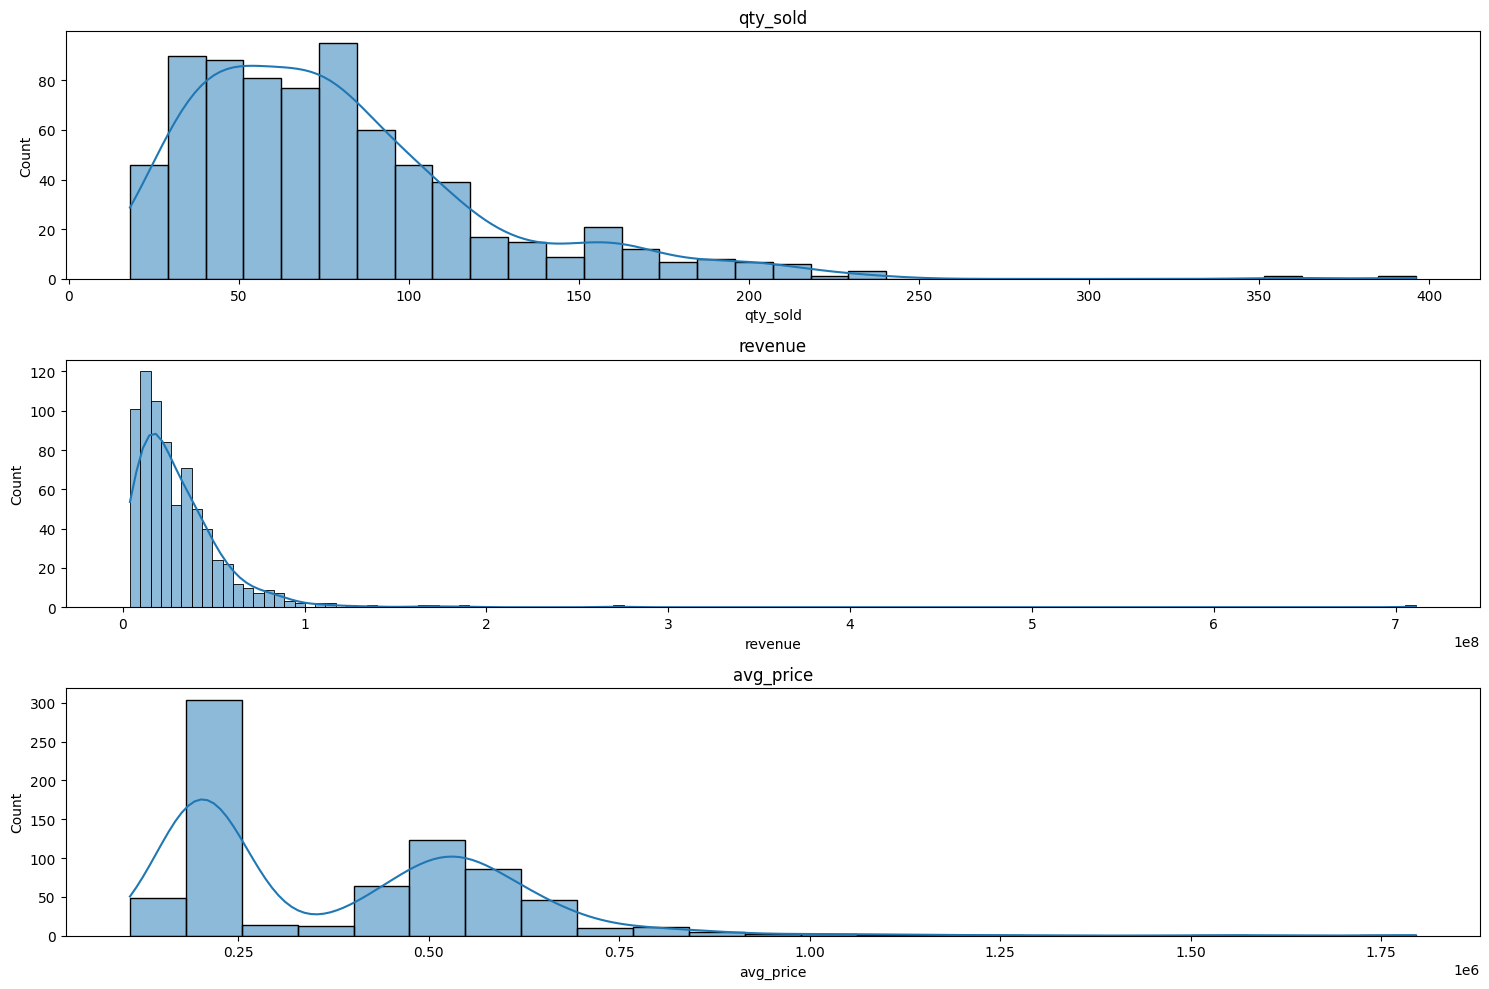

In [104]:
# Define the number of rows and columns for subplots
num_rows = 3
num_cols = (len(num_attribs) + num_rows - 1) // num_rows

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 10))

# Flatten the axes array to iterate over numerical attributes
axes = axes.flatten()

# Iterate over numerical attributes and plot histograms
for i, column in enumerate(num_attribs):
    sns.histplot(df[column], ax=axes[i], kde=True)
    axes[i].set_title(column)

# Hide empty subplots
for j in range(i+1, num_rows*num_cols):
    axes[j].axis('off')

# Adjust layout
plt.tight_layout()
plt.show()


Distribution seems to be right skewed

In [105]:
df.describe()

,date,qty_sold,revenue,avg_price
count,730,730.00,730.00,730.00
mean,2018-04-01 00:00:00,79.31,30729148.62,384870.64
min,2017-10-01 00:00:00,18.00,3995750.00,107570.61
25%,2017-12-31 00:00:00,47.00,13479500.00,201310.29
50%,2018-04-01 00:00:00,70.00,23075200.00,327202.14
75%,2018-07-01 00:00:00,98.00,39072437.50,536150.71
max,2018-09-30 00:00:00,396.00,710999930.00,1795454.37
std,NaN,45.60,35065763.02,209580.58


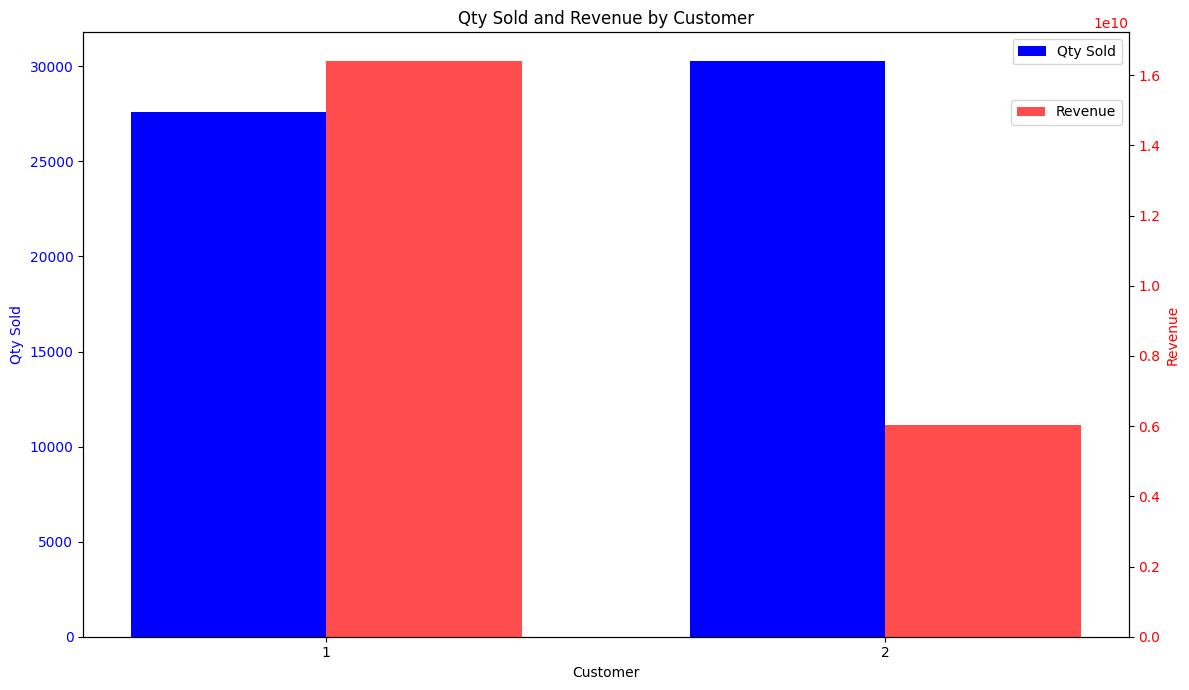

In [106]:

# Group by customer and calculate total qty_sold and revenue
totals = df.groupby('customer').agg({'qty_sold': 'sum', 'revenue': 'sum'}).reset_index()

# Extract totals for plotting
customers = totals['customer']
total_qty_sold = totals['qty_sold']
total_revenue = totals['revenue']

# Create the plot
x = np.arange(len(customers))  # The label locations
width = 0.35  # The width of the bars

fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot bars for qty_sold
bars_qty_sold = ax1.bar(x - width/2, total_qty_sold, width, label='Qty Sold', color='b')

# Create a secondary y-axis for revenue
ax2 = ax1.twinx()  # Instantiate a new y-axis that shares the same x-axis

# Plot bars for revenue on the secondary y-axis
bars_revenue = ax2.bar(x + width/2, total_revenue, width, label='Revenue', color='r', alpha=0.7)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax1.set_xlabel('Customer')
ax1.set_ylabel('Qty Sold', color='b')
ax1.set_title('Qty Sold and Revenue by Customer')
ax1.set_xticks(x)
ax1.set_xticklabels(customers)
ax1.tick_params(axis='y', labelcolor='b')

# Customize the secondary y-axis
ax2.set_ylabel('Revenue', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Add legends with manual positioning at the top right corner
ax1.legend(loc='upper right', bbox_to_anchor=(1, 1))
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.9))

# Show the plot
plt.tight_layout()
plt.show()

1. Customer 1 had bought lower quantity but generate more revenue (2.67 times more)
2. Customer 2 had bought higher quantity but generate much lower revenue

In [107]:
# Convert date column to datetime format
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')

# Filter data by customer
df_customer1 = df[df['customer'] == 1]
df_customer2 = df[df['customer'] == 2]

# Create a DataFrame for the total qty_sold by date
df_total = df.groupby('date').agg({'qty_sold': 'sum', 'revenue': 'sum'}).reset_index()

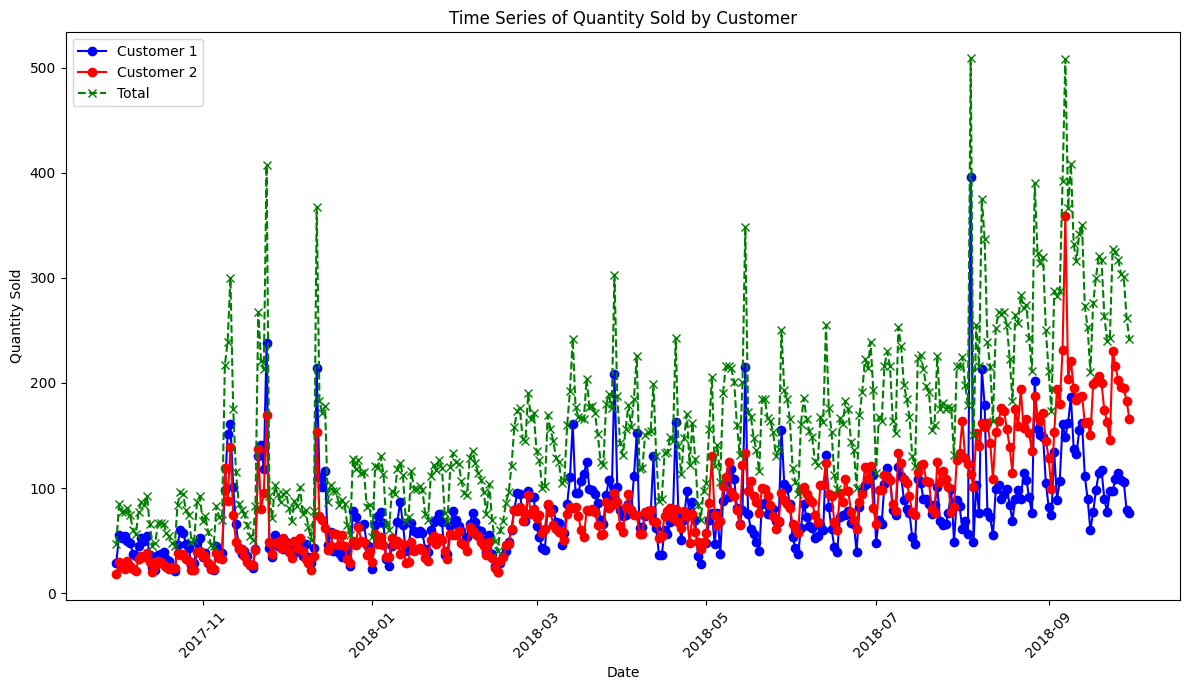

In [108]:
# Plot the time series for qty_sold by customer
plt.figure(figsize=(12, 7))

plt.plot(df_customer1['date'], df_customer1['qty_sold'], marker='o', label='Customer 1', color='b')
plt.plot(df_customer2['date'], df_customer2['qty_sold'], marker='o', label='Customer 2', color='r')
plt.plot(df_total['date'], df_total['qty_sold'], marker='x', linestyle='--', color='g', label='Total')

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.title('Time Series of Quantity Sold by Customer')
plt.legend(loc='upper left')

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

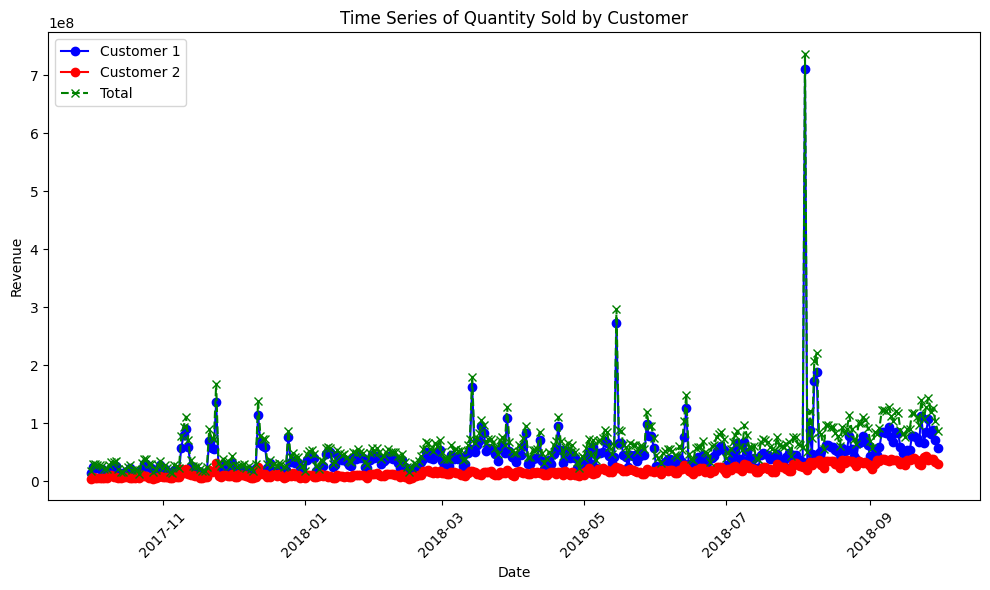

In [109]:
# Plot the time series for qty_sold by customer
plt.figure(figsize=(10, 6))

plt.plot(df_customer1['date'], df_customer1['revenue'], marker='o', label='Customer 1', color='b')
plt.plot(df_customer2['date'], df_customer2['revenue'], marker='o', label='Customer 2', color='r')
plt.plot(df_total['date'], df_total['revenue'], marker='x', linestyle='--', color='g', label='Total')

# Add labels, title, and legend
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Time Series of Quantity Sold by Customer')
plt.legend(loc='upper left')

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

It seems like Customer 1 has significantly more fluctuation in their buying habits.

**Next Steps:**
1. Create two models:
   - One for Customer 1
   - Another for Customer 2


## 3.2 Explanatory Data Analysis

# 4. Time Series Multiplicative Decomposition

In [110]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [111]:
def multiplicative_decomposition(data):
    result = seasonal_decompose(data, model='multiplicative')

    # Assign decomposed components to variables
    trend = result.trend
    seasonal = result.seasonal
    residual = result.resid

    plt.figure(figsize=(20, 20))

    plt.subplot(411)
    plt.plot(data, label='Original', marker='o', linestyle='-')
    plt.legend(loc='best')

    plt.subplot(412)
    plt.plot(trend, label='Trend', marker='o', linestyle='-')
    plt.legend(loc='best')

    plt.subplot(413)
    plt.plot(seasonal, label='Seasonal',marker='o', linestyle='-')
    plt.legend(loc='best')

    plt.subplot(414)
    plt.plot(residual, label='Residuals',marker='o', linestyle='-')
    plt.legend(loc='best')

    plt.tight_layout()
    plt.show()

In [112]:
# Set the date column as the index
df_customer1.set_index('date', inplace=True)
df_customer2.set_index('date', inplace=True)

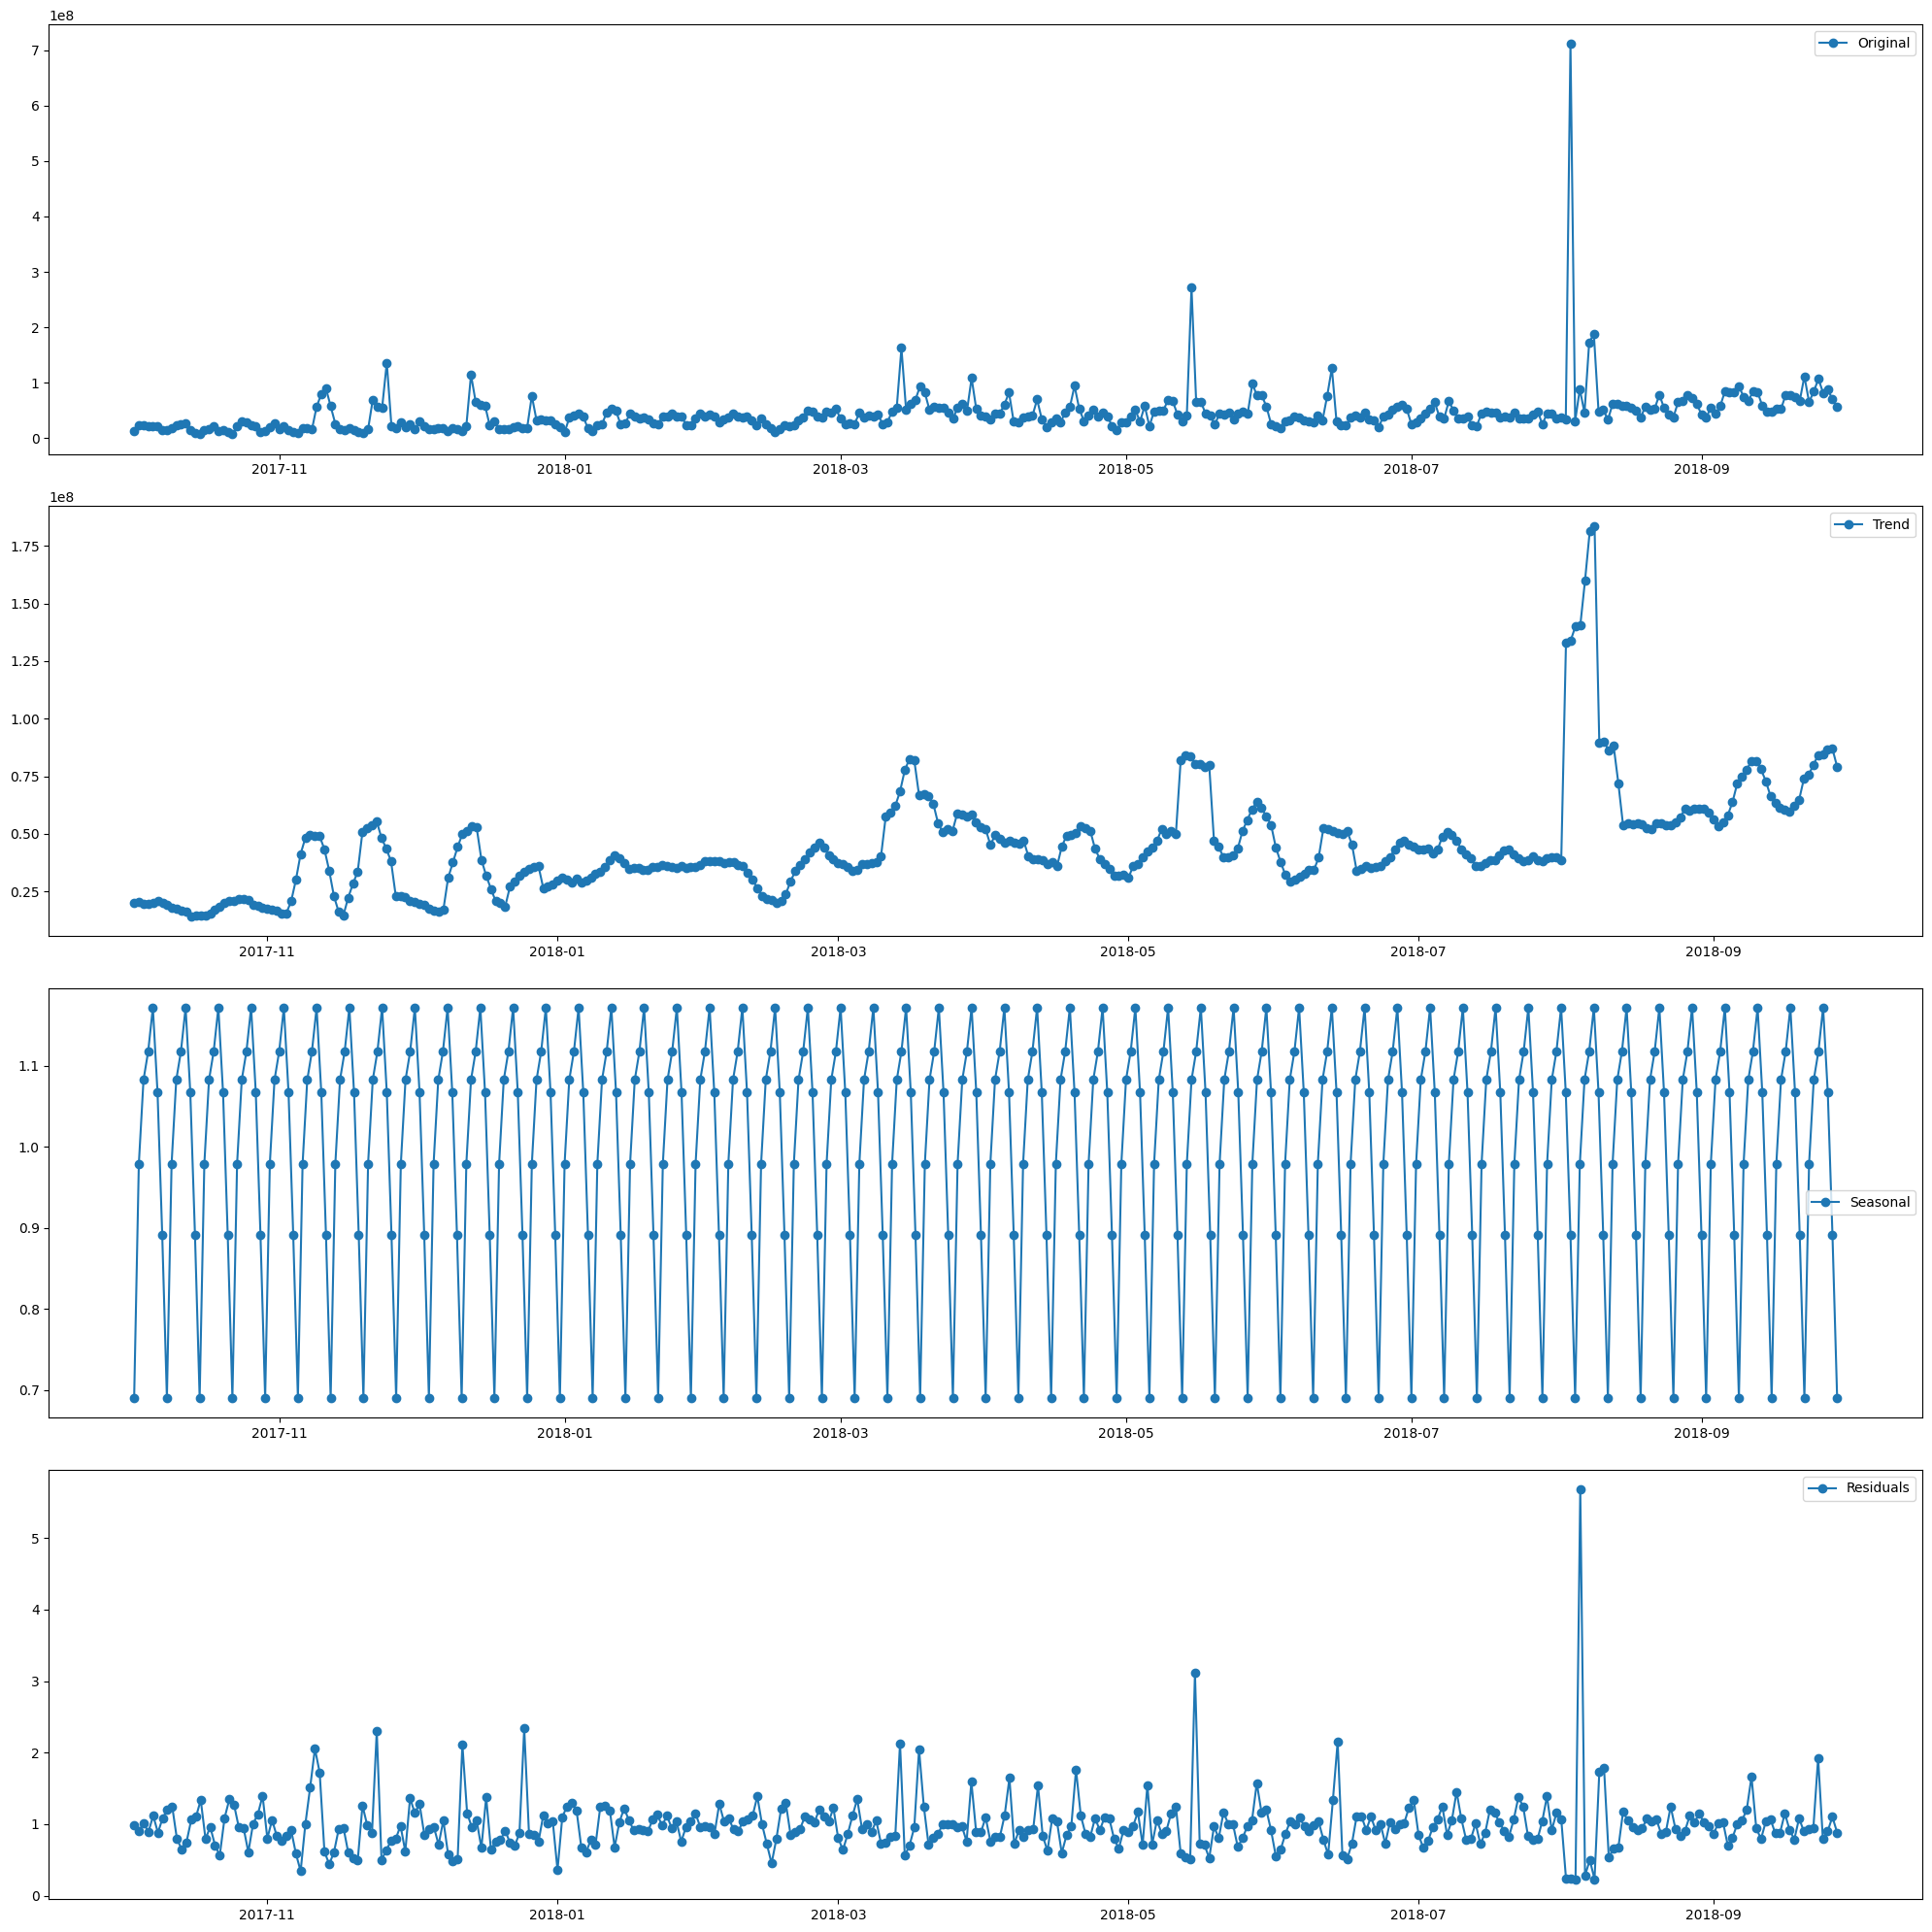

In [113]:
multiplicative_decomposition(df_customer1['revenue'])

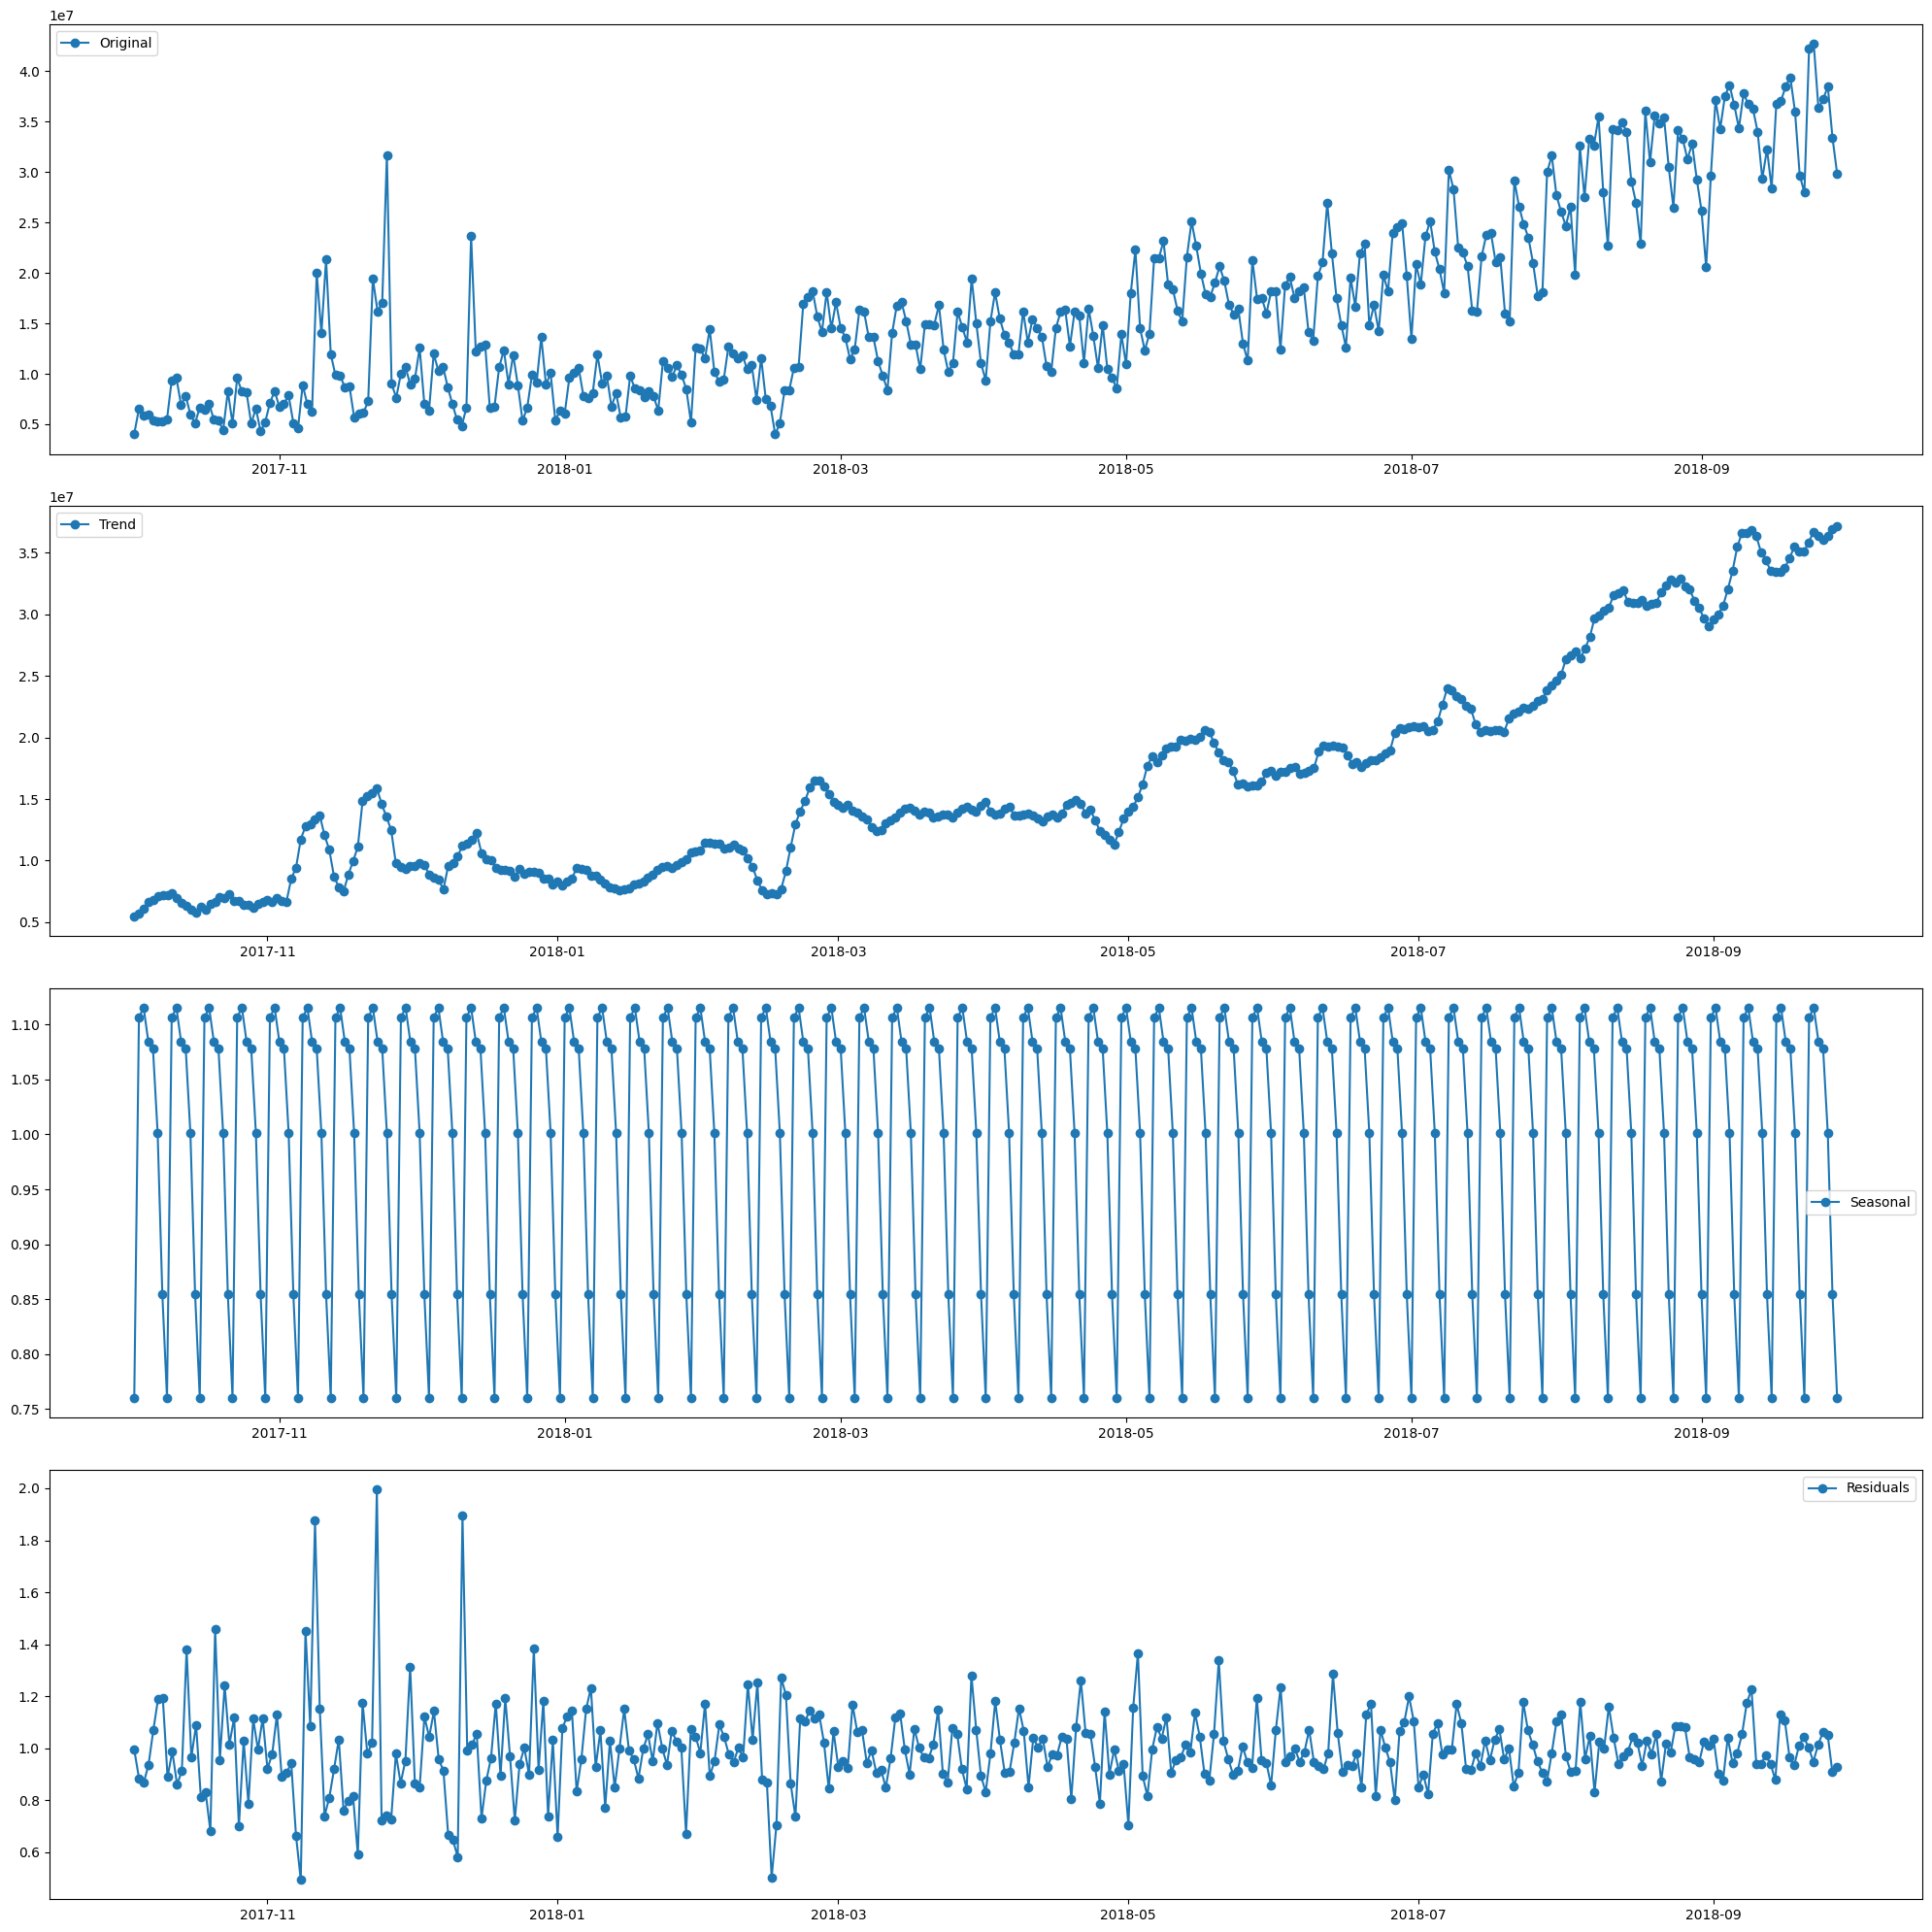

In [114]:
multiplicative_decomposition(df_customer2['revenue'])

In [115]:
def check_seasonality(data):
    # Perform seasonal decomposition
    decomposition = sm.tsa.seasonal_decompose(data)
    
    # Plot the decomposition
    decomposition.plot()
    plt.show()
    
    # Check for seasonality based on the seasonal component
    seasonal_component = decomposition.seasonal
    seasonal_std = seasonal_component.std()
    
    # Define a threshold for detecting seasonality
    threshold = 0.05
    
    if seasonal_std > threshold:
        print("Seasonality detected in the data.")
    else:
        print("No clear seasonality detected in the data.")

## 4.1 Seasonality Analysis

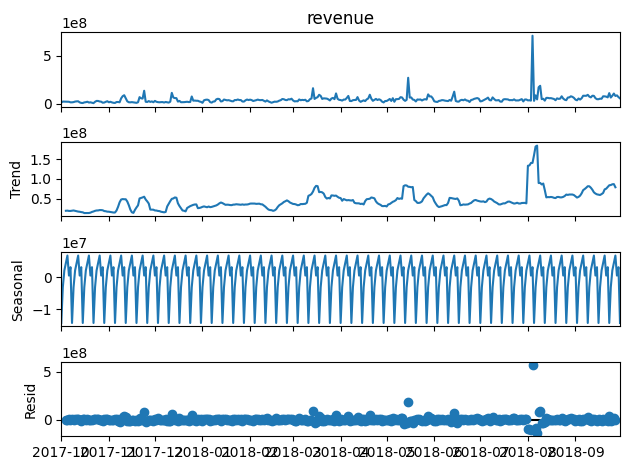

Seasonality detected in the data.


In [116]:
check_seasonality(df_customer1['revenue'])

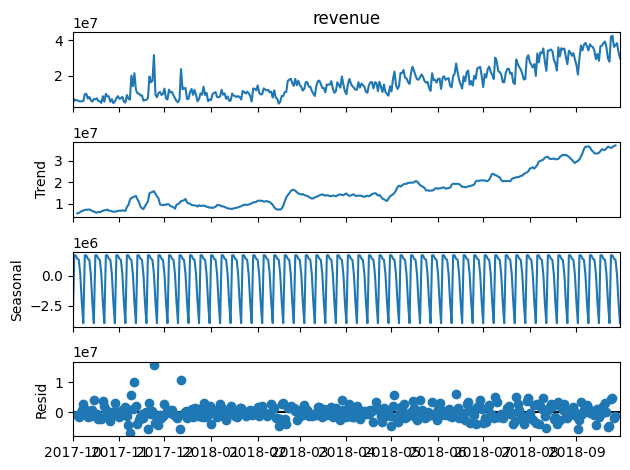

Seasonality detected in the data.


In [117]:
check_seasonality(df_customer2['revenue'])

## 4.2 Stationary Analysis

In [118]:
from statsmodels.tsa.stattools import adfuller

In [119]:
def check_stationary(data):
    # Perform ADF test to check stationarity
    result = adfuller(data)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    if result[1] < 0.05:
        print("The differentiated series is likely stationary (reject the null hypothesis)")
    else:
        print("The differentiated series is likely non-stationary (fail to reject the null hypothesis)")

In [120]:
check_stationary(df_customer1['revenue'])

ADF Statistic: -5.523010596155329
p-value: 1.8593152706529816e-06
Critical Values:
   1%: -3.448645946352023
   5%: -2.869602139060357
   10%: -2.5710650077160495
The differentiated series is likely stationary (reject the null hypothesis)


In [121]:
check_stationary(df_customer2['revenue'])

ADF Statistic: 0.646870387647758
p-value: 0.9887156956899688
Critical Values:
   1%: -3.449336554273722
   5%: -2.8699055166063085
   10%: -2.571226758215748
The differentiated series is likely non-stationary (fail to reject the null hypothesis)


In [122]:
def differentiate_and_check_stationary(series, diff_order):
    # Differentiate the series the specified number of times
    differentiated_series = series.diff(diff_order).dropna()
    
    # Plot the differentiated series
    plt.figure(figsize=(10, 6))
    plt.plot(differentiated_series.index, differentiated_series.values, label=f'{diff_order}th Order Difference')
    plt.title(f'{diff_order}th Order Difference of Time Series')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    # Perform ADF test to check stationarity
    result = adfuller(differentiated_series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')
    if result[1] < 0.05:
        print("The differentiated series is likely stationary (reject the null hypothesis)")
    else:
        print("The differentiated series is likely non-stationary (fail to reject the null hypothesis)")

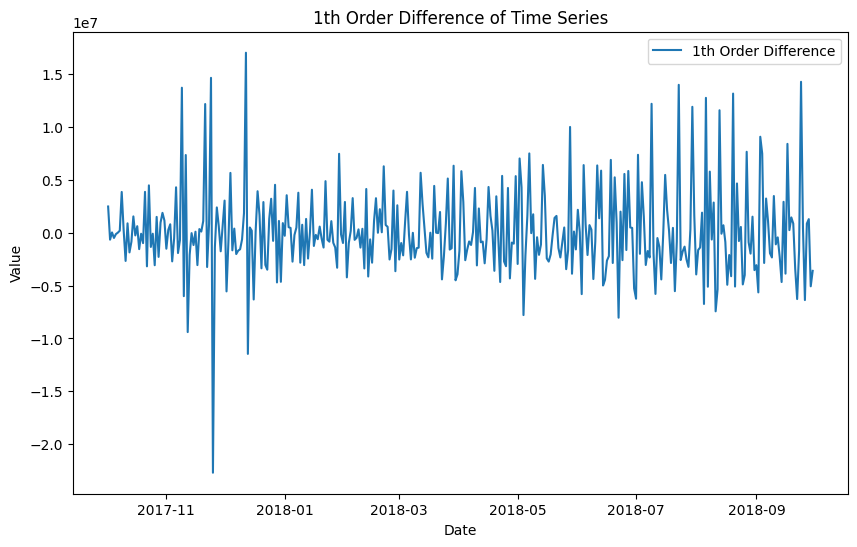

ADF Statistic: -6.410330859793376
p-value: 1.8978148836505784e-08
Critical Values:
   1%: -3.449336554273722
   5%: -2.8699055166063085
   10%: -2.571226758215748
The differentiated series is likely stationary (reject the null hypothesis)


In [123]:
differentiate_and_check_stationary(df_customer2['revenue'],1)

Customer_1's revenue is likely stationary, whereas Customer_2's revenue is not. Therefore, we need to apply a first-order difference to Customer_2's revenue to achieve stationarity, which is necessary for models like ARIMA.

# 5. ACF and PACF charts

In [124]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [125]:
def plot_acf_pacf(series, lags=None):
    # Plot ACF
    plt.figure(figsize=(12, 6))
    plot_acf(series, lags=lags, ax=plt.gca())
    plt.title('Autocorrelation Function (ACF)')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.show()
    
    # Plot PACF
    plt.figure(figsize=(12, 6))
    plot_pacf(series, lags=lags, ax=plt.gca())
    plt.title('Partial Autocorrelation Function (PACF)')
    plt.xlabel('Lag')
    plt.ylabel('Partial Autocorrelation')
    plt.show()

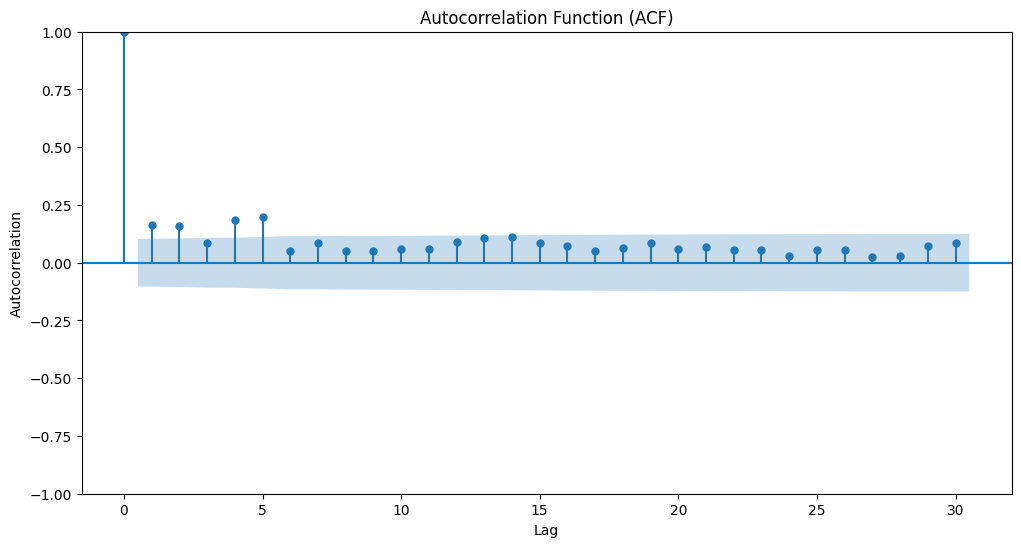

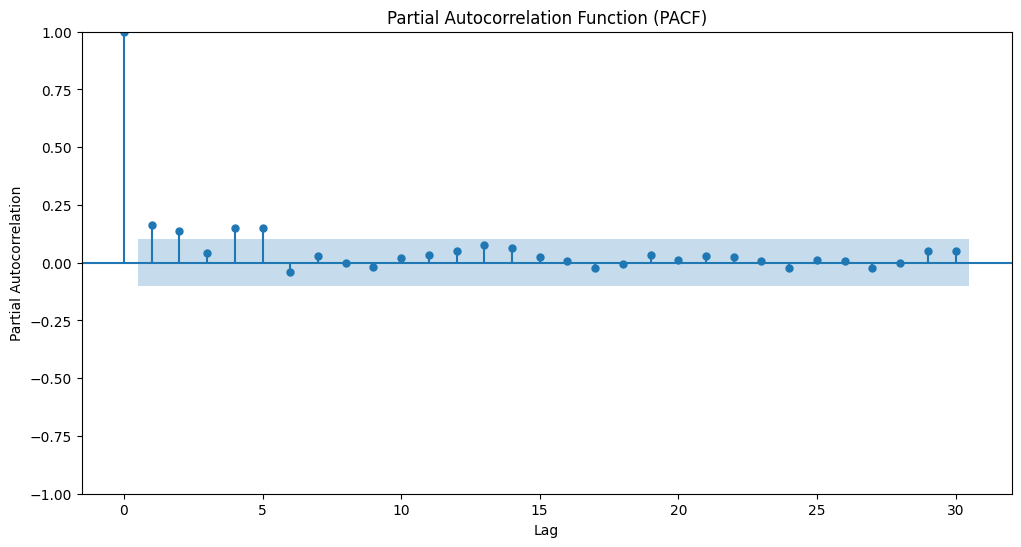

In [126]:
plot_acf_pacf(df_customer1['revenue'], lags=30)  # You can adjust the number of lags as needed

Chose 
* d = 0
* p = 3
* q = 3

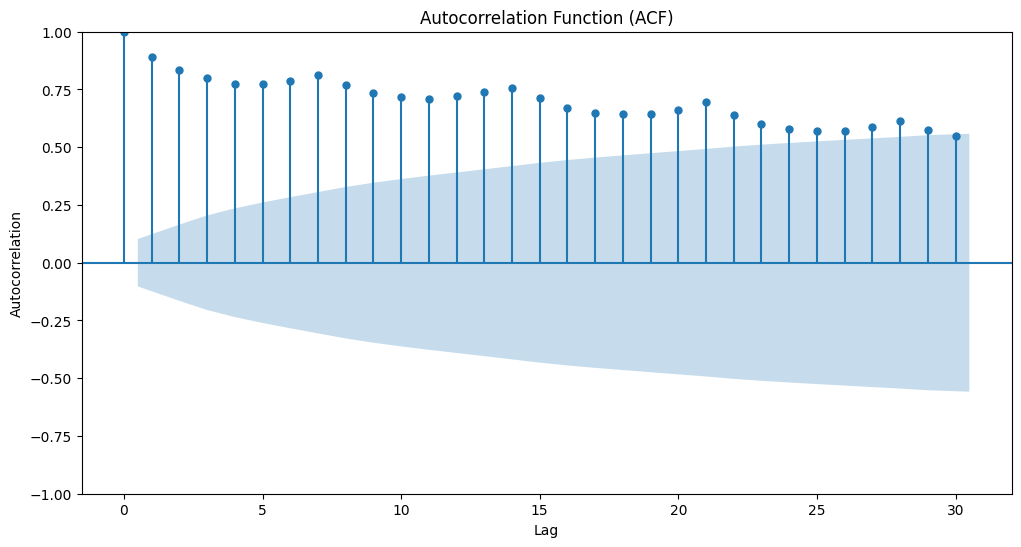

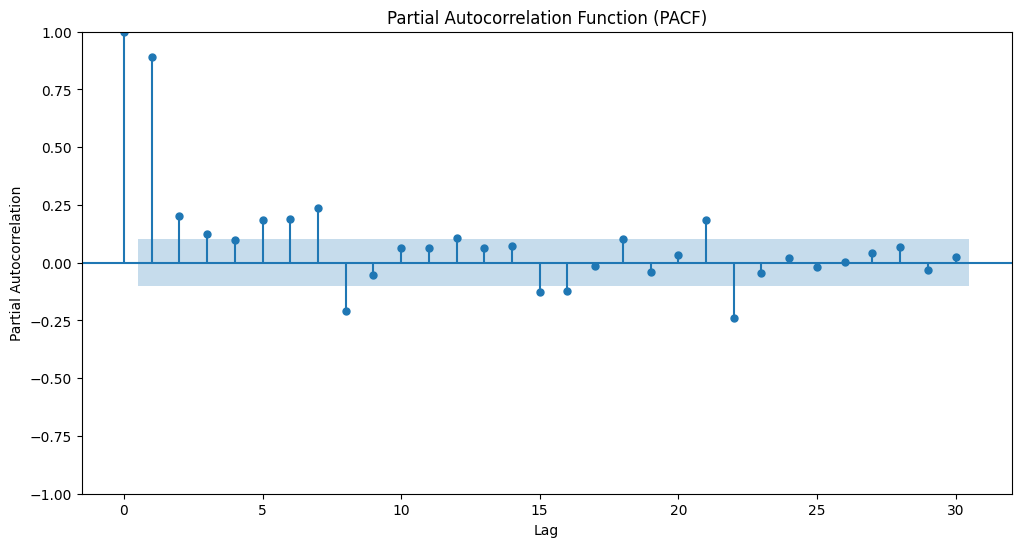

In [127]:
plot_acf_pacf(df_customer2['revenue'], lags=30)  # You can adjust the number of lags as needed

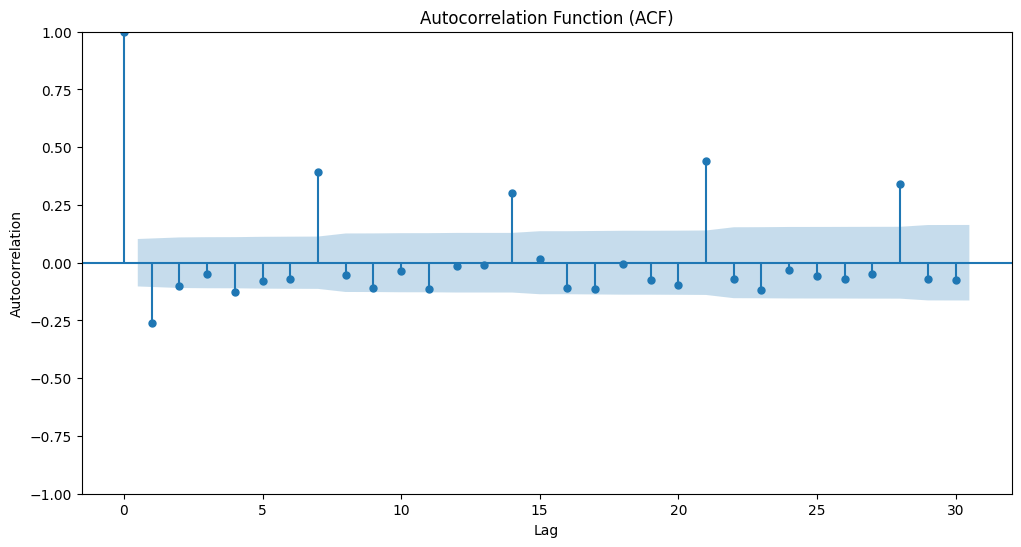

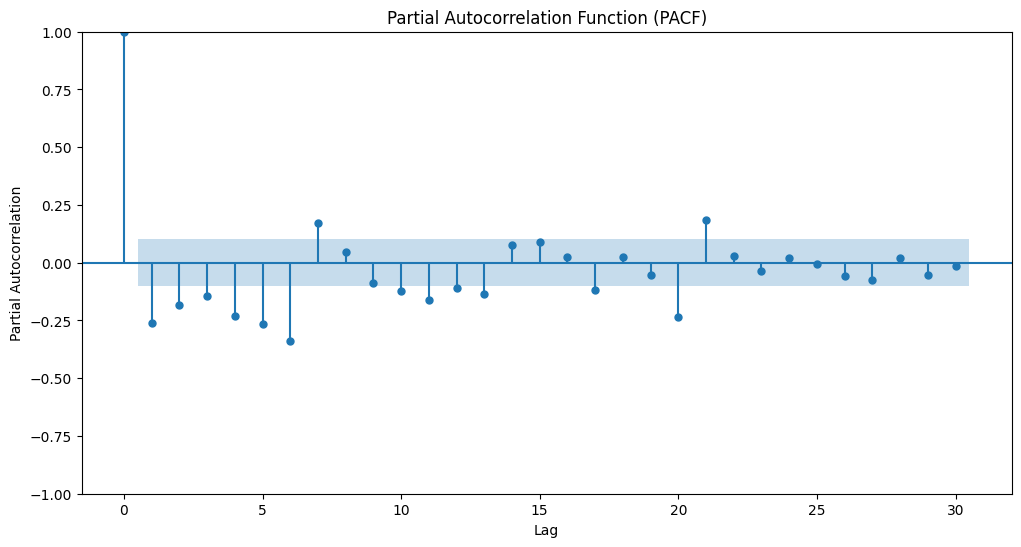

In [128]:
# Differentiate the series the specified number of times
differentiated_series = df_customer2['revenue'].diff(1).dropna()

plot_acf_pacf(differentiated_series, lags=30)  # You can adjust the number of lags as needed

Chose 
* d = 1
* p = 3
* q = 7

# 6. ARIMA Model

In [129]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [131]:
df_customer1.drop(columns=['category_a', 'customer', 'avg_price'], inplace = True)

C:\Users\hamin\AppData\Local\Temp\ipykernel_80516\2076669780.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_customer1.drop(columns=['category_a', 'customer', 'avg_price'], inplace = True)


In [132]:
df_customer1.head()

,qty_sold,revenue
date,,
2017-10-01,29,13178000
2017-10-02,55,23493200
2017-10-03,52,23179200
2017-10-04,54,21963850
2017-10-05,50,21548800


In [149]:
model = ARIMA(df_customer1['revenue'], order=(3, 0, 3))
model_fit = model.fit()

c:\Users\hamin\Desktop\test-kamereo\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\hamin\Desktop\test-kamereo\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\hamin\Desktop\test-kamereo\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [150]:
forecast = model_fit.get_forecast(steps=30)

c:\Users\hamin\Desktop\test-kamereo\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\hamin\Desktop\test-kamereo\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\hamin\Desktop\test-kamereo\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\hamin\Desktop\test-kamereo\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\hamin\Desktop\test-kamereo\.venv\Lib\site-packages\statsm

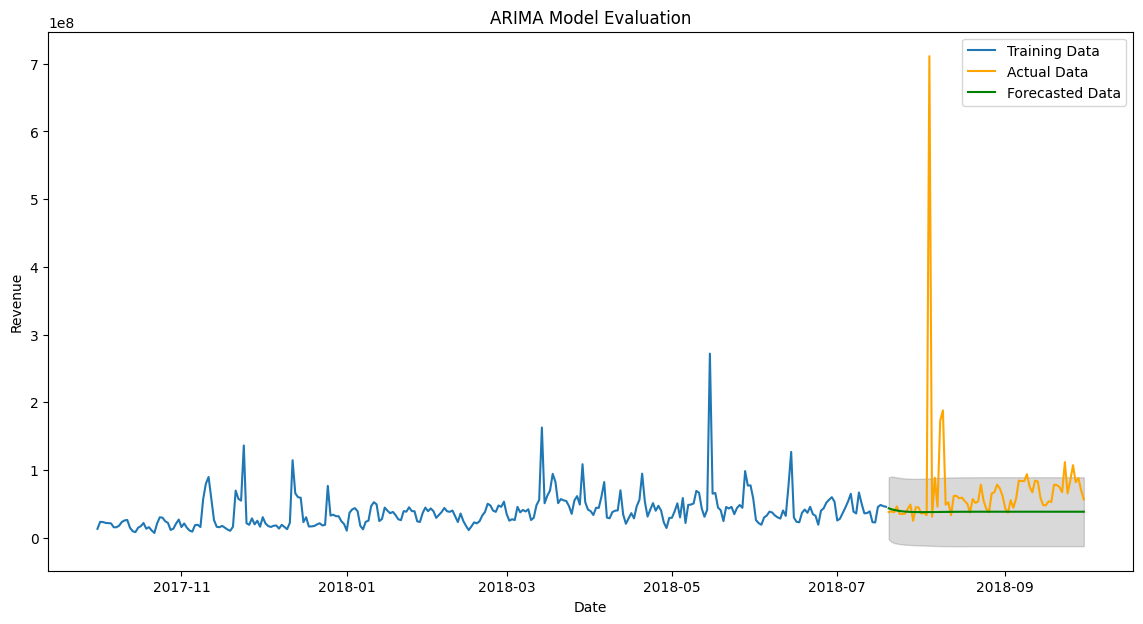

RMSE: 86668079.82434712


In [152]:
# Split the data into train and test
train_size = int(len(df_customer1) * 0.8)
train, test = df_customer1[0:train_size], df_customer1[train_size:len(df_customer1)]

# Fit the ARIMA model on the training dataset
model = ARIMA(train['revenue'], order=(3, 0, 3))
model_fit = model.fit()

# Forecast on the test dataset
test_forecast = model_fit.get_forecast(steps=len(test))
test_forecast_series = pd.Series(test_forecast.predicted_mean, index=test.index)
conf_int = test_forecast.conf_int()

# Calculate the mean squared error
mse = mean_squared_error(test['revenue'], test_forecast_series)
rmse = mse**0.5

# Create a plot to compare the forecast with the actual test data
plt.figure(figsize=(14,7))
plt.plot(train['revenue'], label='Training Data')
plt.plot(test['revenue'], label='Actual Data', color='orange')
plt.plot(test_forecast_series, label='Forecasted Data', color='green')
plt.fill_between(test.index, 
                 conf_int.iloc[:, 0], 
                 conf_int.iloc[:, 1], 
                 color='k', alpha=.15)
plt.title('ARIMA Model Evaluation')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.show()

print('RMSE:', rmse)

# 7. LSTM Model


# 8. Time GPT Model